In [19]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [20]:
def func(v):
  x = v[..., 0]
  y = v[..., 1]
  return x * x + x * y * np.sin(y) - 2 * np.sqrt(y)

In [21]:
x = np.linspace(1e-10, 20, 1000)
y = np.linspace(1e-10, 20, 1000)
X, Y = np.meshgrid(x, y)

V = np.stack((X, Y), axis=-1)
W = func(V)

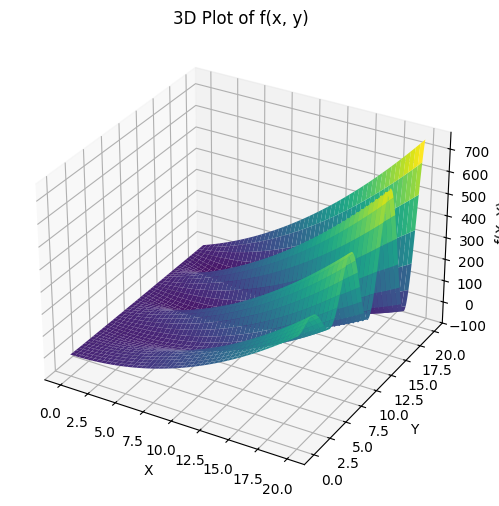

In [22]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, W, cmap='viridis')

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')
ax.set_title('3D Plot of f(x, y)')

plt.show()

In [23]:
v = np.random.random(size=(1000, 2)) * 20
w = func(v)

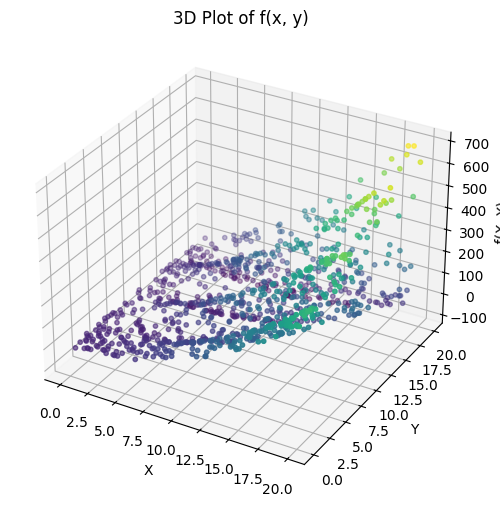

In [24]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(v[..., 0], v[..., 1], w, c=w, cmap='viridis', s=10)

# Labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('f(X, Y)')
ax.set_title('3D Plot of f(x, y)')

plt.show()

In [25]:
def getFeedForwardModel(hiddenLayers):
  model = keras.Sequential()
  model.add(keras.Input(shape=(2,)))
  
  for units in hiddenLayers:
    model.add(keras.layers.Dense(units, activation='relu'))
    
  model.add(keras.layers.Dense(1, activation="linear"))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss="mse", metrics=["mae"])
  return model

def getCascadeForwardModel(hiddenLayers):
  inputLayer = keras.Input(shape=(2,))
  prevOutputLayer = inputLayer
  for units in hiddenLayers:
    outputLayer = keras.layers.Dense(units, activation='relu')(prevOutputLayer)
    prevOutputLayer = keras.layers.Concatenate()([inputLayer, outputLayer])
  outputLayer = keras.layers.Dense(1)(prevOutputLayer)
  model = keras.Model(inputLayer, outputLayer)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss="mse", metrics=["mae"])
  return model

def getElmanModel(hiddenLayers):
  inputLayer = keras.Input(shape=(2,))
  hiddenState = keras.layers.Dense(hiddenLayers[0], activation="relu")(inputLayer)
  for units in hiddenLayers[1:]:
    hiddenState = keras.layers.Dense(units, activation="relu")(hiddenState)
  outputLayer = keras.layers.Dense(1)(hiddenState)
  model = keras.Model(inputLayer, outputLayer)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-2), loss="mse", metrics=["mae"])
  return model

def getMRE(model, x, y):
  predictions = model.predict(x)
  relativeErrors = np.abs((y - predictions) / y)
  mre = np.mean(relativeErrors) * 100
  return mre

In [26]:
feedForwardModelA = getFeedForwardModel([10])
feedForwardModelB = getFeedForwardModel([20])

cascadeForwardModelA = getCascadeForwardModel([20])
cascadeForwardModelB = getCascadeForwardModel([10, 10])

elmanModelA = getElmanModel([15])
elmanModelB = getElmanModel([5, 5, 5])


names = ["Feed Forward A", "Feed Forward B", "Cascade Forward A", "Cascade Forward B", "Elman A", "Elman B"]
models = [feedForwardModelA, feedForwardModelB, cascadeForwardModelA, cascadeForwardModelB, elmanModelA, elmanModelB]

histories = []
evaluations = []

V = V.reshape(1000000, 2)

for model in models:
  histories.append(model.fit(v, w, epochs=1000, verbose=1))
  evaluations.append(getMRE(model, V, W.reshape(1000000, 1)))

Epoch 1/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 38324.6758 - mae: 135.4351 
Epoch 2/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27973.1406 - mae: 113.3640
Epoch 3/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19839.1191 - mae: 100.6732
Epoch 4/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20438.1289 - mae: 107.6506
Epoch 5/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17071.4844 - mae: 98.6004
Epoch 6/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15544.3301 - mae: 93.6406
Epoch 7/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13683.4004 - mae: 84.5334
Epoch 8/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11199.7705 - mae: 76.9753
Epoch 9/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10253.9033 - mae: 75.5841
Epoch 10/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10046.1924 - mae: 74.4439
Epoch 11/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10297.4023 - mae: 77.1136
Epoch 12/1000
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms

In [27]:
print(evaluations)

[np.float64(466.6687533180599), np.float64(519.2825927745624), np.float64(460.1826152427964), np.float64(467.41117362662743), np.float64(405.55834563163995), np.float64(359.24267837207714)]


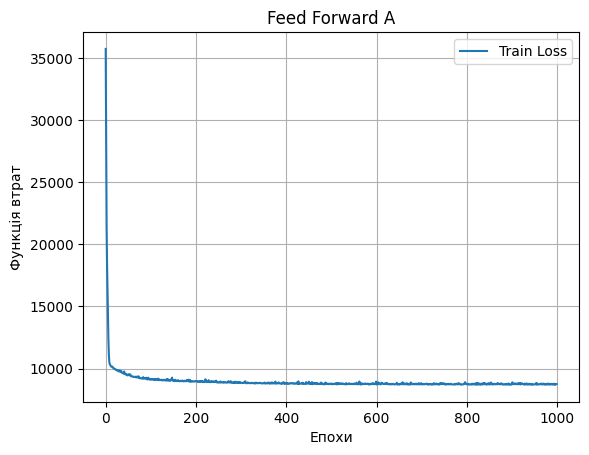

Feed Forward A MRE: 466.6687533180599


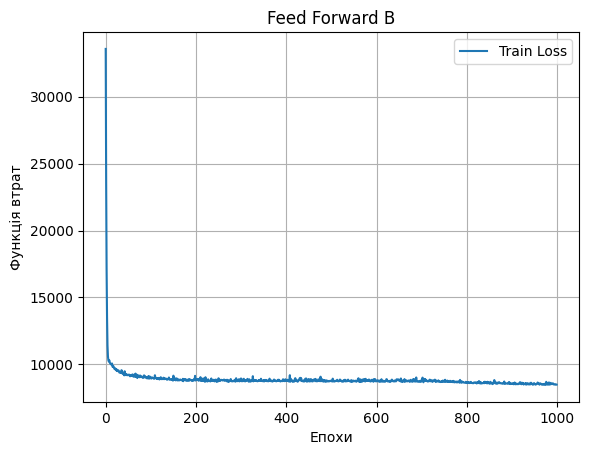

Feed Forward B MRE: 519.2825927745624


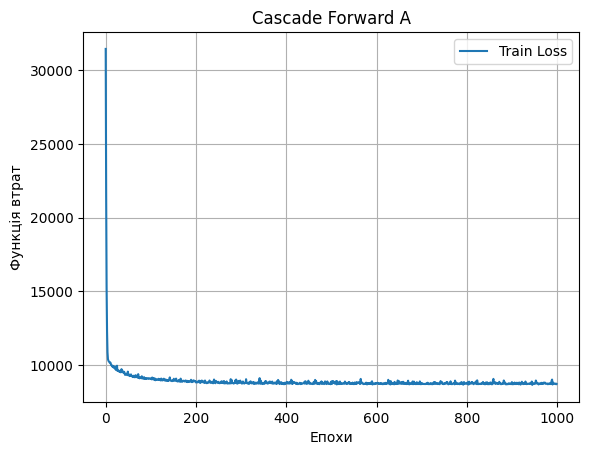

Cascade Forward A MRE: 460.1826152427964


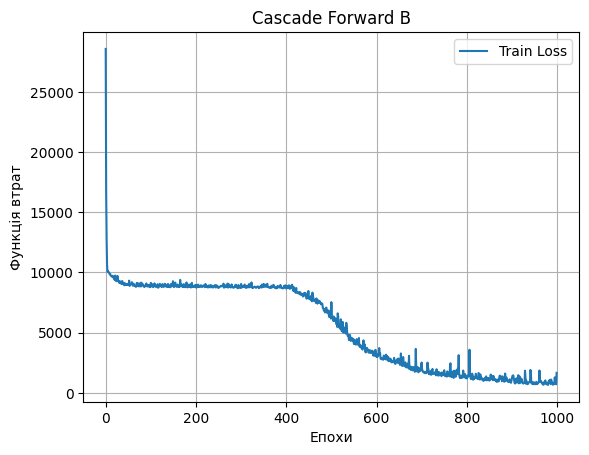

Cascade Forward B MRE: 467.41117362662743


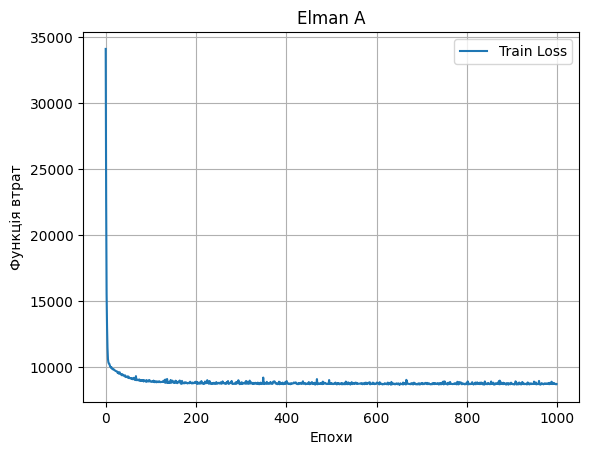

Elman A MRE: 405.55834563163995


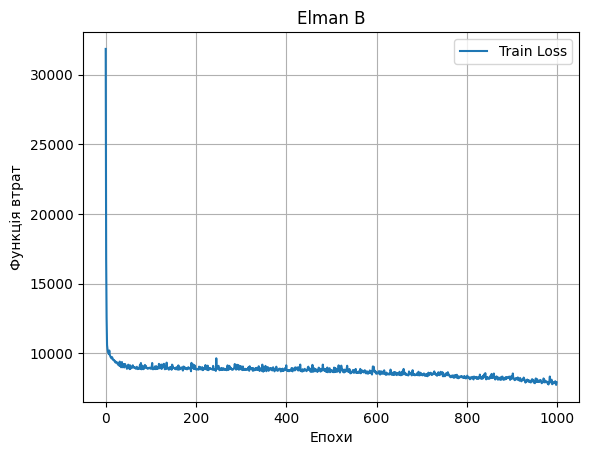

Elman B MRE: 359.24267837207714


In [28]:
for i in range(len(histories)):
  plt.plot(histories[i].history['loss'], label='Train Loss')
  plt.xlabel('Епохи')
  plt.ylabel('Функція втрат')
  plt.title(names[i])
  plt.legend()
  plt.grid()
  plt.show()
  print(f'{names[i]} MRE: {evaluations[i]}')